In [1]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.icospheres

import importlib
importlib.reload(meld_graph)
importlib.reload(meld_graph.models)
importlib.reload(meld_graph.dataset)
importlib.reload(meld_graph.experiment)
importlib.reload(meld_graph.data_preprocessing)

from meld_graph.paths import EXPERIMENT_PATH
import numpy as np

import logging
import argparse
from copy import deepcopy
import os
from functools import reduce
import operator

Setting MELD_DATA_PATH to /home/co-spit1/meld_data
Setting BASE_PATH to /home/co-spit1/meld_data
Setting EXPERIMENT_PATH to /home/co-spit1/meld_experiments/co-spit1
Setting FS_SUBJECTS_PATH to /home/co-spit1/meld_data/output/fs_outputs
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1


In [2]:
def load_config(config_file):
    """load config.py file and return config object"""
    import importlib.machinery, importlib.util

    loader = importlib.machinery.SourceFileLoader("config", config_file)
    spec = importlib.util.spec_from_loader(loader.name, loader)
    config = importlib.util.module_from_spec(spec)
    loader.exec_module(config)
    return config

In [3]:
config = load_config("../scripts/config_files/experiment_config_hannah_synth.py")

## train baseline model

In [4]:
print(config.data_parameters)
print(config.network_parameters)

{'hdf5_file_root': '{site_code}_{group}_featurematrix_combat_6.hdf5', 'site_codes': ['H4'], 'scanners': ['15T', '3T'], 'dataset': 'MELD_dataset_V6.csv', 'group': 'both', 'features_to_exclude': [], 'subject_features_to_exclude': [], 'features': ['.on_lh.lesion.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh'], 'features_to_replace_with_0': [], 'number_of_folds': 10, 'fold_n': 0, 'preprocessing_parameters': {'scaling': None, 'zscore': False}, 'icosphere_parameters': {'distance_type': 'exact'}, 'augment_data': {}, 'combine_hemis': None, 'lobes': False, 'lesion_bias': 10, 'synthetic_data': {'n_subs': 100, 'bias': 1, 'radius': 1}}
{'network_type': 'MoNet', 'model_parameters': {'layer_sizes': [16, 16, 16], 'activation_fn': 'leaky_relu', 'conv_type': 'SpiralConv', 'dim': 2, 'kernel_size': 3, 'spiral_len': 7}, 'training_parameters': {'max_patience': 400, 'num_epochs': 20, 'optimiser': 'sgd', 'optimiser_parameters': {'lr': 0.0001, 'momentum': 0.99, 'nesterov': True}, 'lr_decay': 0, 'loss_dictiona

In [5]:
config.network_parameters['training_parameters']['num_epochs'] = 100
config.network_parameters['name'] += '/pretrain_radius1'
print(config.network_parameters['name'])

22-07-29_synth_3layer/pretrain_radius1


In [6]:
exp = meld_graph.experiment.Experiment(config.network_parameters, config.data_parameters, verbose=logging.INFO)

saving parameter files to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius1/fold_00


In [7]:
trainer = meld_graph.training.Trainer(exp)

In [8]:
trainer.train()

Using coord type exact
getting train val test split
total number of subjects: 86
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 86
total number of subjects: 950
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 942


conv 2 16
conv 16 16
conv 16 16


total number after filtering by scanner ['3T', '15T'], features, lesional_only True: 911
full_feature_list: ['.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh', '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh', '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.wm_FLAIR_1.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.inter_z.asym.intra_z.co

Epoch 15 :: Val   loss 0.005, dice_lesion 0.229, dice_nonlesion 0.984, precision 0.394, recall 0.161, tp 147800.000, fp 227000.000, fn 769200.000, tn 31624400.000
saved_new_best
Epoch 16 :: learning rate 0.0001
Epoch 16 :: Train loss 0.004, dice_lesion 0.240, dice_nonlesion 0.985, precision 0.414, recall 0.168, tp 309012.000, fp 436702.000, fn 1524988.000, tn 63266098.000
Epoch 16 :: Val   loss 0.004, dice_lesion 0.252, dice_nonlesion 0.985, precision 0.435, recall 0.177, tp 162200.000, fp 210400.000, fn 754800.000, tn 31641000.000
saved_new_best
Epoch 17 :: learning rate 0.0001
Epoch 17 :: Train loss 0.004, dice_lesion 0.262, dice_nonlesion 0.985, precision 0.454, recall 0.185, tp 338518.000, fp 406573.000, fn 1495482.000, tn 63296227.000
Epoch 17 :: Val   loss 0.004, dice_lesion 0.276, dice_nonlesion 0.985, precision 0.476, recall 0.195, tp 178600.000, fp 197000.000, fn 738400.000, tn 31654400.000
saved_new_best
Epoch 18 :: learning rate 0.0001
Epoch 18 :: Train loss 0.004, dice_lesi

Epoch 37 :: Val   loss 0.002, dice_lesion 0.705, dice_nonlesion 0.993, precision 0.852, recall 0.601, tp 551200.000, fp 95800.000, fn 365800.000, tn 31755600.000
saved_new_best
Epoch 38 :: learning rate 0.0001
Epoch 38 :: Train loss 0.002, dice_lesion 0.709, dice_nonlesion 0.993, precision 0.854, recall 0.607, tp 1112390.000, fp 190168.000, fn 721610.000, tn 63512632.000
Epoch 38 :: Val   loss 0.002, dice_lesion 0.715, dice_nonlesion 0.993, precision 0.855, recall 0.615, tp 563600.000, fp 95200.000, fn 353400.000, tn 31756200.000
saved_new_best
Epoch 39 :: learning rate 0.0001
Epoch 39 :: Train loss 0.002, dice_lesion 0.718, dice_nonlesion 0.993, precision 0.857, recall 0.619, tp 1134921.000, fp 189304.000, fn 699079.000, tn 63513496.000
Epoch 39 :: Val   loss 0.002, dice_lesion 0.724, dice_nonlesion 0.993, precision 0.859, recall 0.626, tp 574200.000, fp 94000.000, fn 342800.000, tn 31757400.000
saved_new_best
Epoch 40 :: learning rate 0.0001
Epoch 40 :: Train loss 0.002, dice_lesion 

Epoch 59 :: Val   loss 0.002, dice_lesion 0.845, dice_nonlesion 0.996, precision 0.897, recall 0.798, tp 732200.000, fp 84400.000, fn 184800.000, tn 31767000.000
saved_new_best
Epoch 60 :: learning rate 0.0001
Epoch 60 :: Train loss 0.002, dice_lesion 0.845, dice_nonlesion 0.996, precision 0.897, recall 0.798, tp 1464239.000, fp 167834.000, fn 369761.000, tn 63534966.000
Epoch 60 :: Val   loss 0.001, dice_lesion 0.848, dice_nonlesion 0.996, precision 0.898, recall 0.803, tp 736600.000, fp 83400.000, fn 180400.000, tn 31768000.000
saved_new_best
Epoch 61 :: learning rate 0.0001
Epoch 61 :: Train loss 0.001, dice_lesion 0.847, dice_nonlesion 0.996, precision 0.898, recall 0.803, tp 1471975.000, fp 166772.000, fn 362025.000, tn 63536028.000
Epoch 61 :: Val   loss 0.001, dice_lesion 0.850, dice_nonlesion 0.996, precision 0.898, recall 0.807, tp 740000.000, fp 83600.000, fn 177000.000, tn 31767800.000
saved_new_best
Epoch 62 :: learning rate 0.0001
Epoch 62 :: Train loss 0.001, dice_lesion 

Epoch 81 :: Val   loss 0.001, dice_lesion 0.887, dice_nonlesion 0.997, precision 0.908, recall 0.867, tp 795000.000, fp 80600.000, fn 122000.000, tn 31770800.000
saved_new_best
Epoch 82 :: learning rate 0.0001
Epoch 82 :: Train loss 0.001, dice_lesion 0.886, dice_nonlesion 0.997, precision 0.908, recall 0.866, tp 1587473.000, fp 160732.000, fn 246527.000, tn 63542068.000
Epoch 82 :: Val   loss 0.001, dice_lesion 0.889, dice_nonlesion 0.997, precision 0.909, recall 0.869, tp 797200.000, fp 80200.000, fn 119800.000, tn 31771200.000
saved_new_best
Epoch 83 :: learning rate 0.0001
Epoch 83 :: Train loss 0.001, dice_lesion 0.888, dice_nonlesion 0.997, precision 0.909, recall 0.868, tp 1591209.000, fp 159704.000, fn 242791.000, tn 63543096.000
Epoch 83 :: Val   loss 0.001, dice_lesion 0.889, dice_nonlesion 0.997, precision 0.909, recall 0.870, tp 798200.000, fp 79800.000, fn 118800.000, tn 31771600.000
saved_new_best
Epoch 84 :: learning rate 0.0001
Epoch 84 :: Train loss 0.001, dice_lesion 

## finetune using baseline model

In [60]:
config = load_config("../scripts/config_files/experiment_config_hannah_synth.py")
print(config.data_parameters)
print(config.network_parameters)

{'hdf5_file_root': '{site_code}_{group}_featurematrix_combat_6.hdf5', 'site_codes': ['H4'], 'scanners': ['15T', '3T'], 'dataset': 'MELD_dataset_V6.csv', 'group': 'both', 'features_to_exclude': [], 'subject_features_to_exclude': [], 'features': ['.on_lh.lesion.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh'], 'features_to_replace_with_0': [], 'number_of_folds': 10, 'fold_n': 0, 'preprocessing_parameters': {'scaling': None, 'zscore': False}, 'icosphere_parameters': {'distance_type': 'exact'}, 'augment_data': {}, 'combine_hemis': None, 'lobes': False, 'lesion_bias': 10, 'synthetic_data': {'n_subs': 100, 'bias': 1, 'radius': 1}}
{'network_type': 'MoNet', 'model_parameters': {'layer_sizes': [16, 16, 16], 'activation_fn': 'leaky_relu', 'conv_type': 'SpiralConv', 'dim': 2, 'kernel_size': 3, 'spiral_len': 7}, 'training_parameters': {'max_patience': 400, 'num_epochs': 20, 'optimiser': 'sgd', 'optimiser_parameters': {'lr': 0.0001, 'momentum': 0.99, 'nesterov': True}, 'lr_decay': 0, 'loss_dictiona

In [61]:
config.network_parameters['training_parameters']['num_epochs'] = 100
config.data_parameters['synthetic_data']['radius'] = 0.2
config.network_parameters['name'] += '/finetune_radius0.2'
config.network_parameters['training_parameters']['init_weights'] = '22-07-29_synth_3layer/pretrain_radius1/fold_00/best_model.pt'
print(config.network_parameters['name'])

22-07-29_synth_3layer/finetune_radius0.2


In [62]:
exp = meld_graph.experiment.Experiment(config.network_parameters, config.data_parameters, verbose=logging.INFO)

saving parameter files to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/fold_00


In [63]:
trainer = meld_graph.training.Trainer(exp)
trainer.train()

Using coord type exact
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius1/fold_00/best_model.pt
getting train val test split
total number of subjects: 86
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 86
total number of subjects: 950
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 942


conv 2 16
conv 16 16
conv 16 16


total number after filtering by scanner ['3T', '15T'], features, lesional_only True: 911
full_feature_list: ['.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh', '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh', '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.wm_FLAIR_1.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.inter_z.asym.intra_z.co

saved_new_best
Epoch 16 :: learning rate 0.0001
Epoch 16 :: Train loss 0.000, dice_lesion 0.883, dice_nonlesion 1.000, precision 0.889, recall 0.878, tp 233455.000, fp 29084.000, fn 32545.000, tn 65241716.000
Epoch 16 :: Val   loss 0.000, dice_lesion 0.885, dice_nonlesion 1.000, precision 0.892, recall 0.878, tp 116800.000, fp 14200.000, fn 16200.000, tn 32621200.000
saved_new_best
Epoch 17 :: learning rate 0.0001
Epoch 17 :: Train loss 0.000, dice_lesion 0.883, dice_nonlesion 1.000, precision 0.892, recall 0.875, tp 232779.000, fp 28312.000, fn 33221.000, tn 65242488.000
Epoch 17 :: Val   loss 0.000, dice_lesion 0.886, dice_nonlesion 1.000, precision 0.893, recall 0.878, tp 116800.000, fp 14000.000, fn 16200.000, tn 32621400.000
saved_new_best
Epoch 18 :: learning rate 0.0001
Epoch 18 :: Train loss 0.000, dice_lesion 0.883, dice_nonlesion 1.000, precision 0.893, recall 0.874, tp 232357.000, fp 27734.000, fn 33643.000, tn 65243066.000
Epoch 18 :: Val   loss 0.000, dice_lesion 0.885, di

Epoch 38 :: Val   loss 0.000, dice_lesion 0.891, dice_nonlesion 1.000, precision 0.930, recall 0.856, tp 113800.000, fp 8600.000, fn 19200.000, tn 32626800.000
saved_new_best
Epoch 39 :: learning rate 0.0001
Epoch 39 :: Train loss 0.000, dice_lesion 0.889, dice_nonlesion 1.000, precision 0.930, recall 0.851, tp 226416.000, fp 16944.000, fn 39584.000, tn 65253856.000
Epoch 39 :: Val   loss 0.000, dice_lesion 0.891, dice_nonlesion 1.000, precision 0.931, recall 0.854, tp 113600.000, fp 8400.000, fn 19400.000, tn 32627000.000
saved_new_best
Epoch 40 :: learning rate 0.0001
Epoch 40 :: Train loss 0.000, dice_lesion 0.889, dice_nonlesion 1.000, precision 0.931, recall 0.851, tp 226332.000, fp 16678.000, fn 39668.000, tn 65254122.000
Epoch 40 :: Val   loss 0.000, dice_lesion 0.892, dice_nonlesion 1.000, precision 0.933, recall 0.854, tp 113600.000, fp 8200.000, fn 19400.000, tn 32627200.000
saved_new_best
Epoch 41 :: learning rate 0.0001
Epoch 41 :: Train loss 0.000, dice_lesion 0.889, dice_

saved_new_best
Epoch 61 :: learning rate 0.0001
Epoch 61 :: Train loss 0.000, dice_lesion 0.891, dice_nonlesion 1.000, precision 0.936, recall 0.851, tp 226320.000, fp 15582.000, fn 39680.000, tn 65255218.000
Epoch 61 :: Val   loss 0.000, dice_lesion 0.893, dice_nonlesion 1.000, precision 0.936, recall 0.854, tp 113600.000, fp 7800.000, fn 19400.000, tn 32627600.000
saved_new_best
Epoch 62 :: learning rate 0.0001
Epoch 62 :: Train loss 0.000, dice_lesion 0.891, dice_nonlesion 1.000, precision 0.936, recall 0.851, tp 226320.000, fp 15582.000, fn 39680.000, tn 65255218.000
Epoch 62 :: Val   loss 0.000, dice_lesion 0.893, dice_nonlesion 1.000, precision 0.936, recall 0.854, tp 113600.000, fp 7800.000, fn 19400.000, tn 32627600.000
saved_new_best
Epoch 63 :: learning rate 0.0001
Epoch 63 :: Train loss 0.000, dice_lesion 0.891, dice_nonlesion 1.000, precision 0.936, recall 0.851, tp 226320.000, fp 15582.000, fn 39680.000, tn 65255218.000
Epoch 63 :: Val   loss 0.000, dice_lesion 0.893, dice

Epoch 83 :: Val   loss 0.000, dice_lesion 0.898, dice_nonlesion 1.000, precision 0.944, recall 0.857, tp 114000.000, fp 6800.000, fn 19000.000, tn 32628600.000
saved_new_best
Epoch 84 :: learning rate 0.0001
Epoch 84 :: Train loss 0.000, dice_lesion 0.896, dice_nonlesion 1.000, precision 0.944, recall 0.855, tp 227311.000, fp 13582.000, fn 38689.000, tn 65257218.000
Epoch 84 :: Val   loss 0.000, dice_lesion 0.899, dice_nonlesion 1.000, precision 0.944, recall 0.859, tp 114200.000, fp 6800.000, fn 18800.000, tn 32628600.000
saved_new_best
Epoch 85 :: learning rate 0.0001
Epoch 85 :: Train loss 0.000, dice_lesion 0.897, dice_nonlesion 1.000, precision 0.944, recall 0.855, tp 227530.000, fp 13582.000, fn 38470.000, tn 65257218.000
Epoch 85 :: Val   loss 0.000, dice_lesion 0.899, dice_nonlesion 1.000, precision 0.944, recall 0.859, tp 114200.000, fp 6800.000, fn 18800.000, tn 32628600.000
saved_new_best
Epoch 86 :: learning rate 0.0001
Epoch 86 :: Train loss 0.000, dice_lesion 0.898, dice_

## train reference model with small radius

In [65]:
config = load_config("../scripts/config_files/experiment_config_hannah_synth.py")
print(config.data_parameters)
print(config.network_parameters)

{'hdf5_file_root': '{site_code}_{group}_featurematrix_combat_6.hdf5', 'site_codes': ['H4'], 'scanners': ['15T', '3T'], 'dataset': 'MELD_dataset_V6.csv', 'group': 'both', 'features_to_exclude': [], 'subject_features_to_exclude': [], 'features': ['.on_lh.lesion.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh'], 'features_to_replace_with_0': [], 'number_of_folds': 10, 'fold_n': 0, 'preprocessing_parameters': {'scaling': None, 'zscore': False}, 'icosphere_parameters': {'distance_type': 'exact'}, 'augment_data': {}, 'combine_hemis': None, 'lobes': False, 'lesion_bias': 10, 'synthetic_data': {'n_subs': 100, 'bias': 1, 'radius': 1}}
{'network_type': 'MoNet', 'model_parameters': {'layer_sizes': [16, 16, 16], 'activation_fn': 'leaky_relu', 'conv_type': 'SpiralConv', 'dim': 2, 'kernel_size': 3, 'spiral_len': 7}, 'training_parameters': {'max_patience': 400, 'num_epochs': 20, 'optimiser': 'sgd', 'optimiser_parameters': {'lr': 0.0001, 'momentum': 0.99, 'nesterov': True}, 'lr_decay': 0, 'loss_dictiona

In [66]:
# train for longer to make comparable
config.network_parameters['training_parameters']['num_epochs'] = 200
config.data_parameters['synthetic_data']['radius'] = 0.2
config.network_parameters['name'] += '/train_radius0.2'
print(config.network_parameters['name'])

22-07-29_synth_3layer/train_radius0.2


In [67]:
exp = meld_graph.experiment.Experiment(config.network_parameters, config.data_parameters, verbose=logging.INFO)
trainer = meld_graph.training.Trainer(exp)
trainer.train()

saving parameter files to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/train_radius0.2/fold_00
Using coord type exact
getting train val test split
total number of subjects: 86
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 86
total number of subjects: 950
total number of subjects after restricting to subjects from MELD_dataset_V6.csv: 942


conv 2 16
conv 16 16
conv 16 16


total number after filtering by scanner ['3T', '15T'], features, lesional_only True: 911
full_feature_list: ['.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh', '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh', '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh', '.combat.on_lh.wm_FLAIR_1.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.inter_z.asym.intra_z.co

saved_new_best
Epoch 16 :: learning rate 0.0001
Epoch 16 :: Train loss 0.003, dice_lesion 0.045, dice_nonlesion 0.997, precision 0.071, recall 0.033, tp 8892.000, fp 117226.000, fn 257108.000, tn 65153574.000
Epoch 16 :: Val   loss 0.003, dice_lesion 0.047, dice_nonlesion 0.997, precision 0.075, recall 0.035, tp 4600.000, fp 56600.000, fn 128400.000, tn 32578800.000
saved_new_best
Epoch 17 :: learning rate 0.0001
Epoch 17 :: Train loss 0.002, dice_lesion 0.050, dice_nonlesion 0.997, precision 0.080, recall 0.036, tp 9518.000, fp 108892.000, fn 256482.000, tn 65161908.000
Epoch 17 :: Val   loss 0.002, dice_lesion 0.056, dice_nonlesion 0.997, precision 0.093, recall 0.041, tp 5400.000, fp 52800.000, fn 127600.000, tn 32582600.000
saved_new_best
Epoch 18 :: learning rate 0.0001
Epoch 18 :: Train loss 0.002, dice_lesion 0.060, dice_nonlesion 0.997, precision 0.099, recall 0.043, tp 11363.000, fp 103064.000, fn 254637.000, tn 65167736.000
Epoch 18 :: Val   loss 0.002, dice_lesion 0.061, dic

Epoch 38 :: Val   loss 0.001, dice_lesion 0.339, dice_nonlesion 0.998, precision 0.563, recall 0.242, tp 32200.000, fp 25000.000, fn 100800.000, tn 32610400.000
saved_new_best
Epoch 39 :: learning rate 0.0001
Epoch 39 :: Train loss 0.001, dice_lesion 0.340, dice_nonlesion 0.998, precision 0.566, recall 0.243, tp 64662.000, fp 49566.000, fn 201338.000, tn 65221234.000
Epoch 39 :: Val   loss 0.001, dice_lesion 0.348, dice_nonlesion 0.998, precision 0.574, recall 0.250, tp 33200.000, fp 24600.000, fn 99800.000, tn 32610800.000
saved_new_best
Epoch 40 :: learning rate 0.0001
Epoch 40 :: Train loss 0.001, dice_lesion 0.353, dice_nonlesion 0.998, precision 0.580, recall 0.253, tp 67413.000, fp 48748.000, fn 198587.000, tn 65222052.000
Epoch 40 :: Val   loss 0.001, dice_lesion 0.361, dice_nonlesion 0.998, precision 0.588, recall 0.260, tp 34600.000, fp 24200.000, fn 98400.000, tn 32611200.000
saved_new_best
Epoch 41 :: learning rate 0.0001
Epoch 41 :: Train loss 0.001, dice_lesion 0.368, dice

saved_new_best
Epoch 61 :: learning rate 0.0001
Epoch 61 :: Train loss 0.001, dice_lesion 0.560, dice_nonlesion 0.999, precision 0.774, recall 0.439, tp 116651.000, fp 33994.000, fn 149349.000, tn 65236806.000
Epoch 61 :: Val   loss 0.001, dice_lesion 0.565, dice_nonlesion 0.999, precision 0.776, recall 0.444, tp 59000.000, fp 17000.000, fn 74000.000, tn 32618400.000
saved_new_best
Epoch 62 :: learning rate 0.0001
Epoch 62 :: Train loss 0.001, dice_lesion 0.567, dice_nonlesion 0.999, precision 0.778, recall 0.446, tp 118555.000, fp 33750.000, fn 147445.000, tn 65237050.000
Epoch 62 :: Val   loss 0.001, dice_lesion 0.571, dice_nonlesion 0.999, precision 0.783, recall 0.450, tp 59800.000, fp 16600.000, fn 73200.000, tn 32618800.000
saved_new_best
Epoch 63 :: learning rate 0.0001
Epoch 63 :: Train loss 0.001, dice_lesion 0.573, dice_nonlesion 0.999, precision 0.785, recall 0.451, tp 120080.000, fp 32792.000, fn 145920.000, tn 65238008.000
Epoch 63 :: Val   loss 0.001, dice_lesion 0.578, d

Epoch 83 :: Val   loss 0.001, dice_lesion 0.672, dice_nonlesion 0.999, precision 0.835, recall 0.562, tp 74800.000, fp 14800.000, fn 58200.000, tn 32620600.000
saved_new_best
Epoch 84 :: learning rate 0.0001
Epoch 84 :: Train loss 0.001, dice_lesion 0.673, dice_nonlesion 0.999, precision 0.835, recall 0.564, tp 150091.000, fp 29556.000, fn 115909.000, tn 65241244.000
Epoch 84 :: Val   loss 0.001, dice_lesion 0.682, dice_nonlesion 0.999, precision 0.838, recall 0.574, tp 76400.000, fp 14800.000, fn 56600.000, tn 32620600.000
saved_new_best
Epoch 85 :: learning rate 0.0001
Epoch 85 :: Train loss 0.001, dice_lesion 0.686, dice_nonlesion 0.999, precision 0.841, recall 0.579, tp 154083.000, fp 29230.000, fn 111917.000, tn 65241570.000
Epoch 85 :: Val   loss 0.001, dice_lesion 0.691, dice_nonlesion 0.999, precision 0.844, recall 0.585, tp 77800.000, fp 14400.000, fn 55200.000, tn 32621000.000
saved_new_best
Epoch 86 :: learning rate 0.0001
Epoch 86 :: Train loss 0.001, dice_lesion 0.692, dic

saved_new_best
Epoch 106 :: learning rate 0.0001
Epoch 106 :: Train loss 0.000, dice_lesion 0.745, dice_nonlesion 0.999, precision 0.860, recall 0.658, tp 175058.000, fp 28570.000, fn 90942.000, tn 65242230.000
Epoch 106 :: Val   loss 0.000, dice_lesion 0.748, dice_nonlesion 0.999, precision 0.859, recall 0.662, tp 88000.000, fp 14400.000, fn 45000.000, tn 32621000.000
saved_new_best
Epoch 107 :: learning rate 0.0001
Epoch 107 :: Train loss 0.000, dice_lesion 0.745, dice_nonlesion 0.999, precision 0.859, recall 0.659, tp 175298.000, fp 28794.000, fn 90702.000, tn 65242006.000
Epoch 107 :: Val   loss 0.000, dice_lesion 0.749, dice_nonlesion 0.999, precision 0.860, recall 0.663, tp 88200.000, fp 14400.000, fn 44800.000, tn 32621000.000
saved_new_best
Epoch 108 :: learning rate 0.0001
Epoch 108 :: Train loss 0.000, dice_lesion 0.748, dice_nonlesion 0.999, precision 0.860, recall 0.663, tp 176422.000, fp 28794.000, fn 89578.000, tn 65242006.000
Epoch 108 :: Val   loss 0.000, dice_lesion 0.

Epoch 128 :: learning rate 0.0001
Epoch 128 :: Train loss 0.000, dice_lesion 0.781, dice_nonlesion 0.999, precision 0.871, recall 0.708, tp 188432.000, fp 27994.000, fn 77568.000, tn 65242806.000
Epoch 128 :: Val   loss 0.000, dice_lesion 0.784, dice_nonlesion 0.999, precision 0.871, recall 0.713, tp 94800.000, fp 14000.000, fn 38200.000, tn 32621400.000
saved_new_best
Epoch 129 :: learning rate 0.0001
Epoch 129 :: Train loss 0.000, dice_lesion 0.782, dice_nonlesion 0.999, precision 0.871, recall 0.711, tp 189092.000, fp 27994.000, fn 76908.000, tn 65242806.000
Epoch 129 :: Val   loss 0.000, dice_lesion 0.785, dice_nonlesion 0.999, precision 0.872, recall 0.714, tp 95000.000, fp 14000.000, fn 38000.000, tn 32621400.000
saved_new_best
Epoch 130 :: learning rate 0.0001
Epoch 130 :: Train loss 0.000, dice_lesion 0.785, dice_nonlesion 0.999, precision 0.871, recall 0.715, tp 190213.000, fp 28195.000, fn 75787.000, tn 65242605.000
Epoch 130 :: Val   loss 0.000, dice_lesion 0.788, dice_nonle

Epoch 150 :: Train loss 0.000, dice_lesion 0.815, dice_nonlesion 0.999, precision 0.880, recall 0.760, tp 202225.000, fp 27578.000, fn 63775.000, tn 65243222.000
Epoch 150 :: Val   loss 0.000, dice_lesion 0.818, dice_nonlesion 0.999, precision 0.880, recall 0.764, tp 101600.000, fp 13800.000, fn 31400.000, tn 32621600.000
saved_new_best
Epoch 151 :: learning rate 0.0001
Epoch 151 :: Train loss 0.000, dice_lesion 0.817, dice_nonlesion 0.999, precision 0.881, recall 0.762, tp 202819.000, fp 27366.000, fn 63181.000, tn 65243434.000
Epoch 151 :: Val   loss 0.000, dice_lesion 0.821, dice_nonlesion 0.999, precision 0.882, recall 0.767, tp 102000.000, fp 13600.000, fn 31000.000, tn 32621800.000
saved_new_best
Epoch 152 :: learning rate 0.0001
Epoch 152 :: Train loss 0.000, dice_lesion 0.819, dice_nonlesion 0.999, precision 0.883, recall 0.764, tp 203303.000, fp 26918.000, fn 62697.000, tn 65243882.000
Epoch 152 :: Val   loss 0.000, dice_lesion 0.822, dice_nonlesion 0.999, precision 0.884, rec

Epoch 172 :: Train loss 0.000, dice_lesion 0.832, dice_nonlesion 0.999, precision 0.886, recall 0.785, tp 208759.000, fp 26790.000, fn 57241.000, tn 65244010.000
Epoch 172 :: Val   loss 0.000, dice_lesion 0.834, dice_nonlesion 0.999, precision 0.887, recall 0.788, tp 104800.000, fp 13400.000, fn 28200.000, tn 32622000.000
saved_new_best
Epoch 173 :: learning rate 0.0001
Epoch 173 :: Train loss 0.000, dice_lesion 0.832, dice_nonlesion 0.999, precision 0.886, recall 0.785, tp 208760.000, fp 26790.000, fn 57240.000, tn 65244010.000
Epoch 173 :: Val   loss 0.000, dice_lesion 0.834, dice_nonlesion 0.999, precision 0.887, recall 0.788, tp 104800.000, fp 13400.000, fn 28200.000, tn 32622000.000
saved_new_best
Epoch 174 :: learning rate 0.0001
Epoch 174 :: Train loss 0.000, dice_lesion 0.834, dice_nonlesion 0.999, precision 0.887, recall 0.787, tp 209402.000, fp 26790.000, fn 56598.000, tn 65244010.000
Epoch 174 :: Val   loss 0.000, dice_lesion 0.836, dice_nonlesion 0.999, precision 0.887, rec

Epoch 194 :: Train loss 0.000, dice_lesion 0.845, dice_nonlesion 0.999, precision 0.890, recall 0.804, tp 213952.000, fp 26348.000, fn 52048.000, tn 65244452.000
Epoch 194 :: Val   loss 0.000, dice_lesion 0.848, dice_nonlesion 0.999, precision 0.892, recall 0.808, tp 107400.000, fp 13000.000, fn 25600.000, tn 32622400.000
saved_new_best
Epoch 195 :: learning rate 0.0001
Epoch 195 :: Train loss 0.000, dice_lesion 0.845, dice_nonlesion 0.999, precision 0.891, recall 0.804, tp 213966.000, fp 26058.000, fn 52034.000, tn 65244742.000
Epoch 195 :: Val   loss 0.000, dice_lesion 0.849, dice_nonlesion 0.999, precision 0.892, recall 0.809, tp 107600.000, fp 13000.000, fn 25400.000, tn 32622400.000
saved_new_best
Epoch 196 :: learning rate 0.0001
Epoch 196 :: Train loss 0.000, dice_lesion 0.847, dice_nonlesion 0.999, precision 0.892, recall 0.807, tp 214532.000, fp 25990.000, fn 51468.000, tn 65244810.000
Epoch 196 :: Val   loss 0.000, dice_lesion 0.849, dice_nonlesion 0.999, precision 0.892, rec

## Compare results

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
from meld_graph.paths import EXPERIMENT_PATH
import os
from meld_graph.experiment import Experiment, discover_trained_experiments

In [75]:
experiment_paths = discover_trained_experiments(path='/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer')

print(experiment_paths)

experiment_paths = ['/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius1/fold_00', 
                    '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/train_radius0.2/fold_00',
                    '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/fold_00', 
]
exps = [Experiment.from_folder(p) for p in experiment_paths]

['/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius1/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/train_radius0.2/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/finetune_radius0.2/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius0.5/fold_00']


/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius1/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/train_radius0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/pretrain_radius1/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/train_radius0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/fold_00


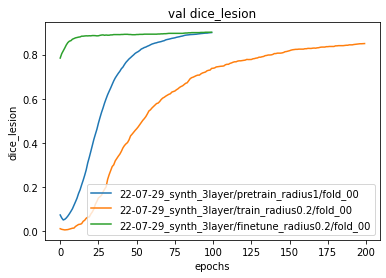

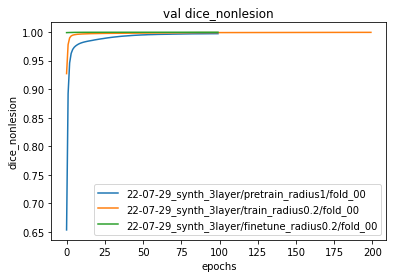

In [76]:
#import seaborn as sns
def plot_scores(exps, score='loss', split='val'):
    scores = []
    fig, ax = plt.subplots(1,1)
    for exp in exps:
        scores = exp.get_scores(split=split)[score]
        ax.plot(scores.index, scores, label=os.path.join(exp.experiment_name, f'fold_{exp.fold:02d}'))
    ax.set_xlabel('epochs')
    ax.set_ylabel(score)
    ax.set_title(f'{split} {score}')
    plt.legend()
    

plot_scores(exps, 'dice_lesion')
plot_scores(exps, 'dice_nonlesion')